<a href="https://colab.research.google.com/github/sukarnhans/Text-Summarization-using-NLP/blob/main/Text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 132.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 129.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.4 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=1782a092c9ce48830b1074befeda5c2f488e28b71130bdb080eaefbdca330bbd
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from simpletransformers.seq2seq import Seq2SeqModel, Seq2SeqArgs

In [ ]:
import torch

print("Is CUDA available?", torch.cuda.is_available())
print("Available GPU(s):", torch.cuda.device_count())


Is CUDA available? True
Available GPU(s): 1


In [ ]:
model_args = Seq2SeqArgs() #setting up the hyperparameters
model_args.num_train_epochs = 20
model_args.no_save = True
model_args.evaluate_generated_text = True1
model_args.evaluate_during_training = True1
model_args.evaluate_during_training_verbose = True
# Enable early stopping
model_args.early_stopping_patience = 3  # Stop after 3 non-improving evals
model_args.early_stopping_delta = 0.01  # Minimum change to qualify as improvement
model_args.early_stopping_metric = "eval_loss"  # Metric to monitor
model_args.early_stopping_metric_minimize = True  # Lower is better
model_args.early_stopping_consider_epochs = True  # Monitor per epoch (not per step)
model_args.overwrite_output_dir = True
model_args.output_dir = "outputs/"
model = Seq2SeqModel(
    encoder_decoder_type="bart",
    encoder_decoder_name="facebook/bart-large",
    args=model_args,
    use_cuda=True  #  Not Force CPU mode
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from simpletransformers.seq2seq import Seq2SeqModel, Seq2SeqArgs

In [ ]:
import zipfile

# Correct path to your ZIP file
zip_path = "/content/Reviews.csv.zip"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")  # Extracts contents into /content/

print("✅ File unzipped successfully!")


✅ File unzipped successfully!


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load full dataset (skip bad lines)
df = pd.read_csv("/content/Reviews.csv", on_bad_lines='skip')

# Drop rows with missing values in 'Text' or 'Summary'
df.dropna(subset=['Text', 'Summary'], inplace=True)

# Remove duplicate [Text, Summary] pairs
df.drop_duplicates(subset=["Text", "Summary"], inplace=True)

# Use ALL data: format as list of [input_text, target_text]
full_data = df[['Text', 'Summary']].values.tolist()

# Sample 125 rows from cleaned data
sampled_data = pd.DataFrame(full_data, columns=["input_text", "target_text"]).sample(n=125, random_state=42)

# Split into 100 training and 25 evaluation
train_df = sampled_data.iloc[:100].reset_index(drop=True)
eval_df = sampled_data.iloc[100:].reset_index(drop=True)

# Print stats and samples
print(f"Total rows after cleaning: {len(df)}")
print(f"Training set size: {len(train_df)}")
print(f"Evaluation set size: {len(eval_df)}")

print("\nTraining Sample:")
print(train_df.head())

print("\nEvaluation Sample:")
print(eval_df.head())


Total rows after cleaning: 394967
Training set size: 100
Evaluation set size: 25

Training Sample:
                                          input_text  \
0  If you want to cook healthily for your family,...   
1  The package reads: "Product of USA, China, Tha...   
2  I have never had such great turnout for my Chr...   
3  This is very good.  It surpassed my expectatio...   
4  My wife is an amazing cook -- and she's Italia...   

                                        target_text  
0  If You Like to Cook Healthy for Your Family.....  
1               Some package and origin information  
2                the best oils for my holiday candy  
3                           mimic creme healthy top  
4                     Unbelievably great product!!!  

Evaluation Sample:
                                          input_text  \
0  This formula gave my 4 month old daughter gas ...   
1  Supermarket Cherry Pie Filling is too sweet, t...   
2  I bought this product on a whim because I love...

In [ ]:
train_df

,input_text,target_text
0,"If you want to cook healthily for your family,...",If You Like to Cook Healthy for Your Family.....
1,"The package reads: ""Product of USA, China, Tha...",Some package and origin information
2,I have never had such great turnout for my Chr...,the best oils for my holiday candy
3,This is very good. It surpassed my expectatio...,mimic creme healthy top
4,My wife is an amazing cook -- and she's Italia...,Unbelievably great product!!!
...,...,...
95,Tea box arrived in perfect condition. Logos pl...,Very pleased
96,Earth's Best Baby Food<br />My favorite brand ...,Great Baby Food and a Great First Veggie Variety
97,This marmalade is so light and tasty on toast....,love prickly pear food items!
98,"My bichon poodle mix is very, very picky about...",My picky puppy loves these


In [ ]:
eval_df

,input_text,target_text
0,This formula gave my 4 month old daughter gas ...,gas & fussy
1,"Supermarket Cherry Pie Filling is too sweet, t...",Cherry Pie or Cherry Cobler
2,I bought this product on a whim because I love...,mango gravy
3,If you are looking for a healthy treat with no...,Natural Treats
4,Yum! This bunny was excellent. Great for dark ...,solid dark chocolate bunny
5,"These mints are pretty tasty, though not what ...",Yummy Mints
6,I picked up a jar of Dickinson's Vanilla Curd ...,Delicious! Outstanding! Five Stars
7,You have pork rinds auto shipped to your house...,Jeff Foxworthy says you might be a redneck if....
8,I think people thought I was crazy to buy 6 bo...,Love!!
9,I thought this was very good. It was really c...,"A healthy, tasty, granola like snack."


In [ ]:

def count_matches(labels, preds):
    print(labels)
    print(preds)
    return sum(
        [
            1 if label == pred else 0
            for label, pred in zip(labels, preds)
        ]
    )

In [ ]:
# Train the model
#model.train_model(train_df, eval_data=eval_df)


In [ ]:
# Train the model with the custom metric
model.train_model(train_df, eval_data=eval_df, count_matches=count_matches)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/seq2seq/seq2seq_model.py:726: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/seq2seq/seq2seq_model.py:750: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/seq2seq/seq2seq_model.py:1211: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:698: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `2.0` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['This formula gave my 4 month old daughter gas & she became very fussy while on', 'Supermarket Cherry Pie Filling is too sweet, too gluey, and really rather', 'I bought this product on a whim because I love trying new things and this one sounded', 'If you are looking for a healthy treat with no preservatives or refined sugars, Frank', 'Yum! This bunny was excellen

Running Epoch 2 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Earthly!', 'Sweet, delicious!', 'I hate this stuff. Seriously.', 'Freshly Natural', 'Happy Easter!', 'These mints are pretty tasty!', 'Wonderful!', 'These are awesome!', 'I love this stuff.I think people thought I was crazy to buy these', 'I liked this!', 'Zevicia delicious!', 'Beautiful apricots!', 'Sleep well tonight.This tea actually has a soothing, relaxing e

Running Epoch 3 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Add Toxic Ingredients', 'Cherry Pie', "I hate this stuff. Isn't very appealing.", 'I love these cookies.', 'I love this chocolate Easter Bunny', 'These mints are pretty tasty!', 'I love this stuff!', 'These are great!', 'I love this stuff.', 'I loved this!', 'Zesty!', 'I love these apricots!', 'I love this tea!', 'I love this tea!', 'I love this stuff.', 'These t

Running Epoch 4 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Add extra DHA and ARA', 'Cherry Pie Filling', 'I hate this product.', 'I love these!', 'I love this!', 'These mints are pretty tasty!', 'I love it!', 'I love these pork rinds', 'I love it!', 'I love this!', "Zevicia Isn't a typical soda", 'I love these apricots!', 'My favorite tea!', 'I love this tea!', 'I love this stuff!', 'Great for you', 'I LOVE THIS PRODUCT'

Running Epoch 5 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Addition of DHA and ARA', 'Cherry Pie Filling', "I can't use it over my chicken", 'I love these!', 'Yummy!', 'Not what I expected', 'I love it!', 'I love these pork rinds', 'I think people thought I was crazy to buy these.', 'I thought this was very good.', "Zevia isn't like other sodas", 'A Jerky Apricot', 'Makes a great morning tea!', 'Love it!', 'Great Oatmeal

Running Epoch 6 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Add DHA and ARA', 'Cherry Pie Filling', "I can't use it.", 'Great product!', 'Great product!', 'Not what I expected', 'A blast of Vanilla Curd', 'Great product', 'Addiction', 'Great snack!', 'Zevia tastes like a real soda', 'A great product!', 'Makes a great tea!', 'Love it!', 'Great Oatmeal', 'Great for you', 'YELLOW LAB LOVES THIS FOOD', 'Coffee-like Coconut Gr

Running Epoch 7 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Add DHA and ARA', 'Sour Pitted Cherry Pie Filling', "I can't use it.", 'Moldy', 'Great product!', 'Makes a bit of a difference', 'I love it!', 'Pork rinds', 'Addiction', 'Very good', "Zevia isn't a soda", 'A great product!', 'Makes a relaxing, relaxing drink', 'Love it!', 'Great Oatmeal', 'Great Macadamia Nuts', 'YELLOW LAB LOVES THIS FOOD', 'Coffee granule', 'Co

Running Epoch 8 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Add DHA and ARA', 'Sour Pitted Cherry Pie Filling', "I can't use this product!", 'Moldy', 'Great product!', 'Makes a little too much mint for my taste', 'I love it!', 'Great product', 'Addiction', 'Great', 'Zevia is a very tart drink', 'A great selection of apricots', 'Makes a relaxing, relaxing drink', 'Love it!', 'Great Oatmeal', 'Great Macadamia Nuts', 'YELLOW

Running Epoch 9 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Add DHA and ARA', 'Sour Pitted Cherries', "I can't use it", "Mold Doesn't Affect These", 'Great product!', 'Not what I expected', 'I love it!', 'Great product', 'Addiction', 'Great snack for a quick morning snack', 'Zevia is not a typical soda', 'Great Apricots', 'Mild sedative', 'Love it!', 'Great Oatmeal', 'Great Macadamia Nuts', 'My dog loves it!', 'Dire', 'Gr

Running Epoch 10 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
["Add DHA and ARA to Baby's Only formula", 'Sour Pitted Cherries', "Doesn't look like real food", "Mold Doesn't Affect the Flavor", 'great product!', 'Melty mints', 'I love it!', 'great product!', 'Add me as another convert to this product!', 'Very good!', 'Zevia tastes like real soda!', 'A Jerky Apricot!', "Makes a relaxing, relaxing drink for a good night's rest!

Running Epoch 11 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Add DHA and ARA', 'Sour Pitted Cherries', "Doesn't look like real food", "Mold Doesn't Expire", 'great chocolate', 'melts in your mouth...not in your hands', 'A blast of Vanilla Curd', 'great product', 'Add me as another convert', 'Very good', 'Very tart', 'Sunmaid Apricots', 'Makes a relaxing, relaxing drink', 'Love it!', 'great product', 'Healthy Macadamia nuts

Running Epoch 12 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Add DHA and ARA to this formula!', 'Try it!', "I can't even eat it", 'Mold free and not too sweet', 'Great selection!', 'melts in your mouth... kinda.', "I can't believe how good this stuff is!", 'Great Low carb Pork Rinds', 'Add me as another convert to this product!', 'Great snack for a quick morning snack', 'Not a fan', 'Sun-maid Apricots', "Makes a most enjoy

Running Epoch 13 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Add DHA and ARA', 'Sour Pitted Cherries', "Doesn't look like real food", 'Healthy Treat', 'Dark chocolate Easter Bunny', 'Melts in your mouth...but not in your hands', 'Total surprise!', 'great product!', 'Add me as another convert to this product!', 'Great snack!', 'Tasty!', 'Sun-maid apricots', "Makes a relaxing drink for a good night's sleep!", 'Superior tea!'

Running Epoch 14 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Add me as a last resort!', 'Try it!', "Doesn't look like real food", 'Mold free and not too sweet', 'Great selection!', 'melts in your mouth... not in your hands', 'I love this stuff!', 'Great low carb snacks - and not your fathers', 'Add me as another convert to this product!', 'Great snack for a quick morning snack.', "Doesn't taste like soda...", 'Sun-maid apr

Running Epoch 15 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Add DHA & ARA', 'Too sweet for my family', 'Does not look like gravy', 'Mold!', 'great item', 'melts in your mouth...', 'Delicious!', 'great product', 'Add me as another convert to this product!', 'Very Satisfied', 'Not Entirely Satisfied', 'Sun-maid apricots are a superior source of fiber', 'mimic', 'SUPER!', 'great item', 'Healthy Macadamia nuts', 'my dog loves

Running Epoch 16 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Add DHA & ARA', 'Sour Pittted Cherry Pie Filling', 'Does not look like real food', 'Mold can happen', 'great item', 'melts in your mouth... not in your hands', 'Overwhelming!', 'These are my favorite low carb snacks', 'Add me as another convert to this stuff!', 'Good snack for a quick morning snack.', "Doesn't taste like soda...", 'Sun-maid apricots are a favorit

Running Epoch 17 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Add DHA & ARA', 'Sour Pittered Cherry Pie Filling', 'Does not look like real food', 'Moldy', 'Great item', 'Not Entirely Satisfied', 'Delicious!', 'great selection', 'Add me as another convert to this stuff!', 'Good snack - very tasty', "Doesn't taste like soda", 'Sun-maid apricots', 'Nice Aftertaste', 'Great tea!', 'Great item', 'Great Macadamia nuts', 'My dog l

Running Epoch 18 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Add DHA & ARA', 'Sour Pittted Cherry Pie Filling', 'Does not look like real food', "Mold Doesn't Expire", 'great item!', 'Melts in your mouth, not in your hands', 'Delicious!', 'great product - and very tasty!', 'Add me as another convert to this stuff!', 'Good snack - very good!', "Doesn't taste like soda...", 'Sun-maid apricots are a favorite!', 'Nice Aftertast

Running Epoch 19 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Add DHA & ARA', 'Sour Pittted Cherry Pie Filling', 'Does not look like real food', "Mold doesn't bother me", 'great item', 'Melts in your mouth... not in your hands', 'Delicious!', 'great product', 'Add me as another convert to this stuff!!!', 'Good snack - very tasty', 'Does not taste like soda', 'Sun-maid apricots are a favorite', 'Nice', 'SUPER!', 'great produ

Running Epoch 20 of 20:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['gas & fussy', 'Cherry Pie or Cherry Cobler', 'mango gravy', 'Natural Treats', 'solid dark chocolate bunny', 'Yummy Mints', 'Delicious! Outstanding! Five Stars', 'Jeff Foxworthy says you might be a redneck if....', 'Love!!', 'A healthy, tasty, granola like snack.', 'Very healthy', 'exemplary value', 'Actually does relax you', 'The Best Tea!', 'Delicious', 'Macadamia Nuts: Unsalted', 'Purina Pro', "Don't buy this product unless you are looking for shredded coconut", 'Delicious!', 'Not the one I was looking for...', 'A little weird', 'Excellent Quality!', 'Thick hearty noodles!', 'Great as a gift', 'High Fructose Corn Syrup']
['Add DHA & ARA', 'Sour PITTED CHERRIES', 'Does not look like real food', "Mold doesn't bother me", 'Dark chocolate Easter Bunny', 'melts in your mouth... not in your hands', 'Delicious!', 'great product', 'Add me as another convert to this stuff!!!', 'Good snack - very tasty!', 'Does not taste like soda', 'Sun-maid apricots are a favorite', 'Nice Aftertaste', 'SUP

(260,
 {'global_step': [13,
   26,
   39,
   52,
   65,
   78,
   91,
   104,
   117,
   130,
   143,
   156,
   169,
   182,
   195,
   208,
   221,
   234,
   247,
   260],
  'eval_loss': [11.933725357055664,
   7.717594146728516,
   5.674592971801758,
   4.797545433044434,
   3.9062650203704834,
   3.016099214553833,
   2.1666524410247803,
   1.4451714754104614,
   0.9087055325508118,
   0.5674154162406921,
   0.4005075693130493,
   0.3125399351119995,
   0.2952902317047119,
   0.26216208934783936,
   0.2796962857246399,
   0.27729594707489014,
   0.25708359479904175,
   0.27147480845451355,
   0.26772719621658325,
   0.2672593295574188],
  'train_loss': [12.164591789245605,
   8.840970039367676,
   6.455004692077637,
   5.2675395011901855,
   4.388969421386719,
   3.4652466773986816,
   2.572251796722412,
   1.7986758947372437,
   1.1818687915802002,
   0.6741118431091309,
   0.37578755617141724,
   0.26905280351638794,
   0.14066261053085327,
   0.09437583386898041,
   0.130332529

In [ ]:

# # Evaluate the model
results = model.eval_model(eval_df)

  0%|          | 0/25 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
results

{'eval_loss': 0.2672593295574188, 'count_matches': 0}

In [ ]:
# Use the model for prediction
print(model.predict(
        [
          "I bought this organic peanut butter a couple of months ago, and I wanted to use it in various recipes before sharing my thoughts. First of all, the packaging was great — it arrived in a sturdy jar with a safety seal, and there was no leakage or damage during shipping. As for the taste and quality, it has exceeded my expectations in every way. The consistency is smooth and creamy, making it perfect for spreading on toast, blending into smoothies, or even adding to oatmeal and baked goods. I’ve used it in protein bars, cookies, and even as a base for savory sauces — and each dish turned out amazing! The rich, nutty flavor is natural and not overly sweet, which I really appreciate. It doesn’t contain any added sugar or preservatives, which is a huge plus for me. Cleanup is simple too — the jar wipes clean easily and the lid seals tightly. One minor downside is the oil separation, which is normal for natural peanut butters, but stirring it the first time can be a bit messy. Also, the price is slightly higher than regular brands, but the quality justifies the cost. Overall, I’m extremely happy with this purchase and would recommend it to anyone looking for a healthier, delicious alternative to conventional peanut butter. It has become a staple in my pantry and I’ll definitely be buying it again."
        ]
    )
)


Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['Organic peanut butter is a favorite!']


In [ ]:
# Use the model for prediction
print(model.predict(
        [
          "I’ve been trying different coffee brands for years, and I finally decided to give this small-batch, organic dark roast a try. I’ve been drinking it every morning for the past several weeks, and I can confidently say it’s one of the best coffees I’ve ever had. First off, the aroma is incredible — the moment you open the bag, you’re hit with rich, chocolatey and slightly smoky notes. The beans were freshly roasted and sealed in a resealable bag, which helped preserve their freshness. I typically grind the beans right before brewing, and the flavor it delivers is deep, bold, and smooth, with no bitterness or burnt aftertaste. It works great with both a French press and a drip coffee maker, though I prefer it with the French press for a fuller flavor. I’ve also used it for cold brew and it turned out exceptionally well — strong but not overpowering. One thing I appreciate is that it’s ethically sourced and certified organic, which aligns with my values. The price is a bit higher than store-bought brands, but the quality is well worth it. My only complaint is that it’s not available in larger size packs. Overall, this coffee has quickly become a favorite in my household, and I’ll definitely be ordering it regularly.Let me know if you'd like a review for another food item — like snacks, beverages, sauces, or health supplements!"
        ]
    )
)


Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

["The best coffee I've ever had"]


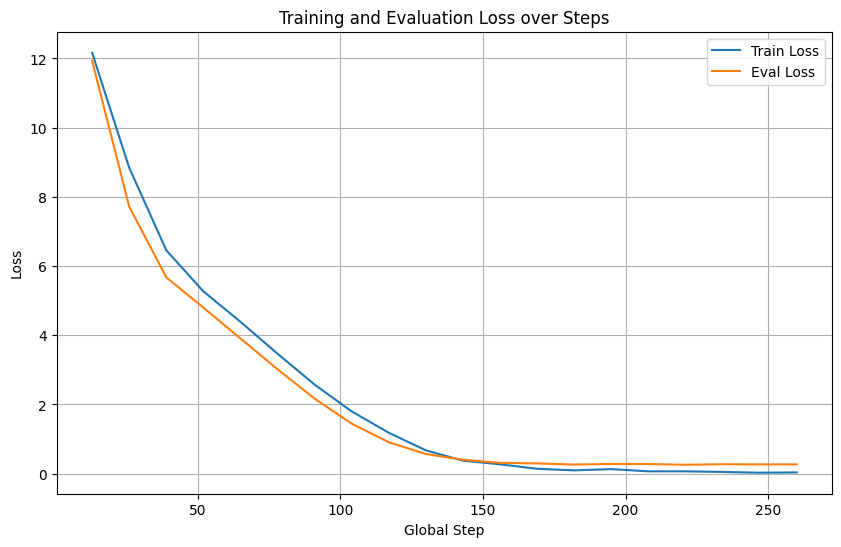

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Path to the log file generated by simpletransformers (under the output directory)
log_file = "outputs/training_args.json"  # You can check your output dir
loss_file = "outputs/training_progress_scores.csv"  # This is the main loss log file

# Check if file exists
if os.path.exists(loss_file):
    df = pd.read_csv(loss_file)
    plt.figure(figsize=(10, 6))

    # Plot training loss if available
    if 'train_loss' in df.columns:
        plt.plot(df['global_step'], df['train_loss'], label='Train Loss')

    # Plot eval loss if available
    if 'eval_loss' in df.columns:
        plt.plot(df['global_step'], df['eval_loss'], label='Eval Loss')

    plt.xlabel('Global Step')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss over Steps')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"No loss log found at {loss_file}")


In [ ]:
!pip install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
from bert_score import score
import pandas as pd

# Assuming you already have eval_df with input_text and target_text
# and you’ve generated predictions from your model:
inputs = eval_df["input_text"].tolist()
references = eval_df["target_text"].tolist()
predictions = model.predict(inputs)

# Compute BERTScore
P, R, F1 = score(predictions, references, lang="en", verbose=True)

# Display average scores
print(f"\n📊 Average BERTScore Precision: {P.mean():.4f}")
print(f"📊 Average BERTScore Recall: {R.mean():.4f}")
print(f"📊 Average BERTScore F1: {F1.mean():.4f}")


Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:698: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `2.0` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.30 seconds, 83.97 sentences/sec

📊 Average BERTScore Precision: 0.8503
📊 Average BERTScore Recall: 0.8462
📊 Average BERTScore F1: 0.8477
